## Music Genre Classification – Introduction to Speech Processing

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os, random, shutil
from tqdm.notebook import tqdm
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models

sns.set(style = "whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

Mounted at /content/drive


In [2]:
data_path = "/content/drive/MyDrive/Music Genre Classification/data"
genres_audio_path = f"{data_path}/genres_original"
images_path = f"{data_path}/images_original"
features_30_path = f"{data_path}/features_30_sec.csv"
features_3_path = f"{data_path}/features_3_sec.csv"

df_30 = pd.read_csv(features_30_path)
df_3 = pd.read_csv(features_3_path)
display(df_30.columns)
display(df_3["label"].value_counts())
display(df_30["label"].value_counts())

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

,count
label,
blues,1000
jazz,1000
pop,1000
reggae,1000
metal,1000
disco,999
classical,998
hiphop,998
rock,998


,count
label,
blues,100
classical,100
country,100
disco,100
hiphop,100
jazz,100
metal,100
pop,100
reggae,100


In [3]:
genres = sorted(os.listdir(genres_audio_path))
display(genres)

df_30

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


## Visualization

### 1. Sample Rate

In [ ]:
audio_file = f"{genres_audio_path}/country/country.00000.wav"
y, sr = librosa.load(audio_file, sr = None)

def load_genre_audio(genre, index = 0, duration = 30):
    genre_dir = os.path.join(genres_audio_path, genre)
    files = sorted(os.listdir(genre_dir))
    audio_path = os.path.join(genre_dir, files[index])
    y, sr = librosa.load(audio_path, sr = 22050, duration = duration)
    return y, sr

print("Sample rate:", sr)
print("Duration (sec):", len(y)/sr)

Sample rate: 22050
Duration (sec): 30.081632653061224


* A sample rate is how many times per second an analog audio signal is "snapped" or measured to create a digital recording, measured in Hertz (Hz) or kilohertz (kHz) (e.g., 44.1 kHz = 44,100 samples/second). Higher sample rates capture more detail, resulting in better quality.

* The analog-to-digital conversion has two steps: sampling and quantization. To sample a signal, we measure its amplitude at a particular time; the sampling rate is the number of samples taken per second.

* To accurately measure a wave, we must have at least two samples in each cycle: one measuring the positive part of the wave and one measuring the negative part. More than two samples per cycle increases the amplitude accuracy, but fewer than two samples causes the frequency of the wave to be completely missed.

* Thus, the maximum frequency wave that can be measured is one whose frequency is half the sample rate (since every cycle needs two samples). This maximum frequency for a given sampling rate is called the Nyquist frequency.

### 2. Waveform

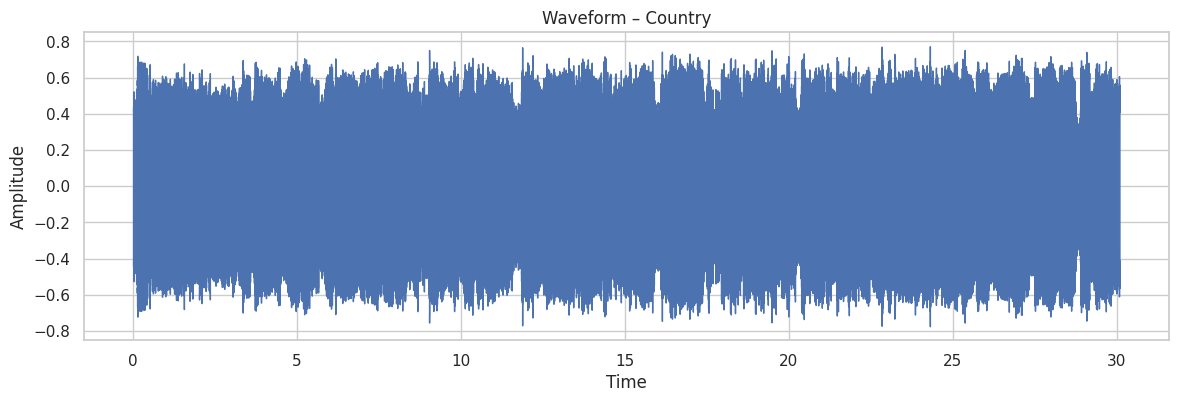

In [ ]:
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y, sr = sr)
plt.title("Waveform – Country")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

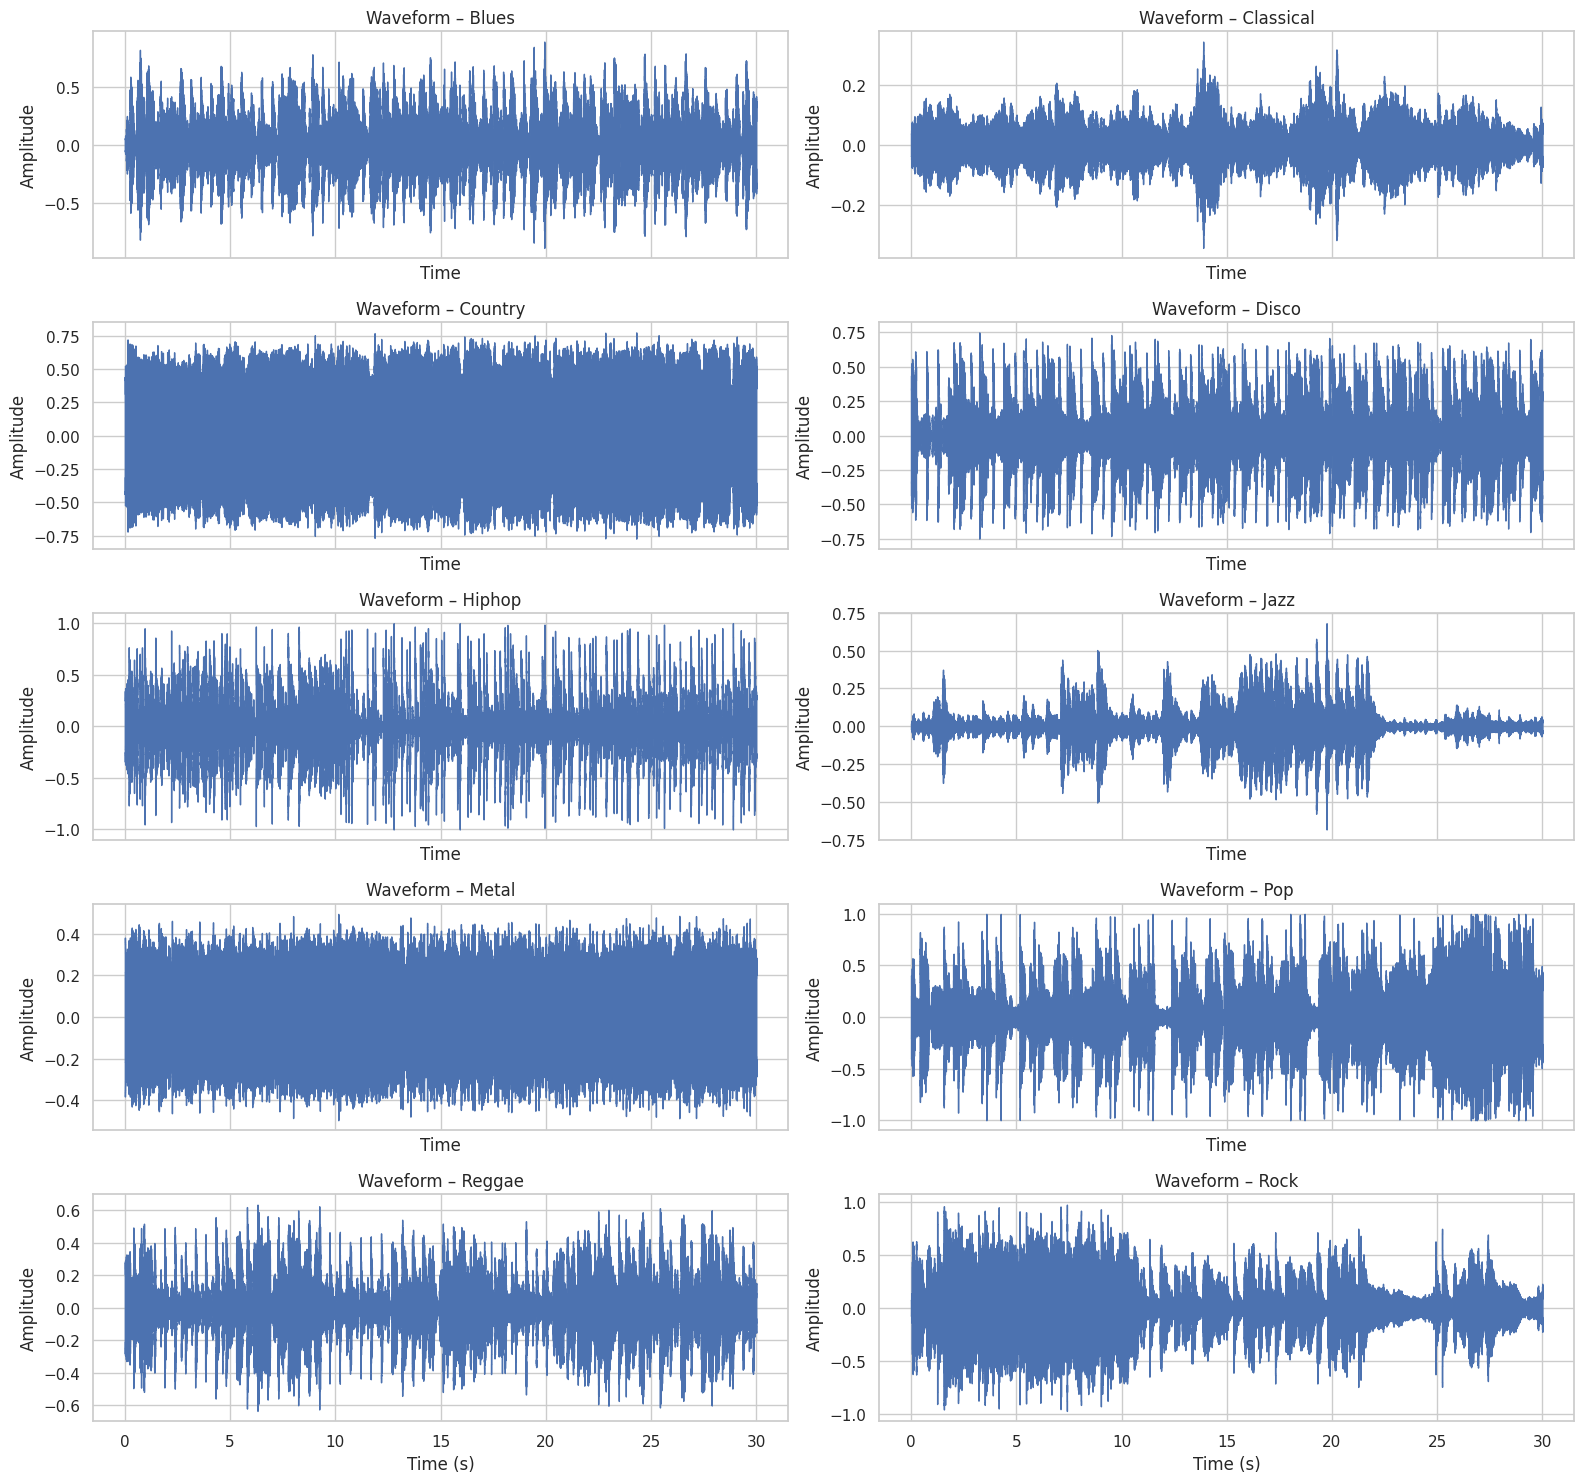

In [ ]:
rows = len(genres) // 2
fig, axes = plt.subplots(rows, 2, figsize=(16, 3 * rows), sharex=True)

for i, genre in enumerate(genres):
    y, sr = load_genre_audio(genre)
    ax = axes[i // 2, i % 2]
    librosa.display.waveshow(y, sr=sr, ax=ax)
    ax.set_title(f"Waveform – {genre.capitalize()}")
    ax.set_ylabel("Amplitude")

for ax in axes[-1]:
    ax.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

* A waveform shows raw audio amplitude over time. Amplitude corresponds to the intensity or "loudness" of the sound at each moment. Microphone captures analog pressure → ADC (Analog-to-Digital Converter) → Sampled at rate **sr** (e.g. 22050 Hz).

* A speech signal is then represented by a sequence of numbers $x_n$, which represent the relative air pressure at time-instant
 $n \in N$.

* Waveform alone is useless for ML: No frequency info, hard to compare genres directly, human hearing ≠ raw time signal.

### 3. Spectrogram

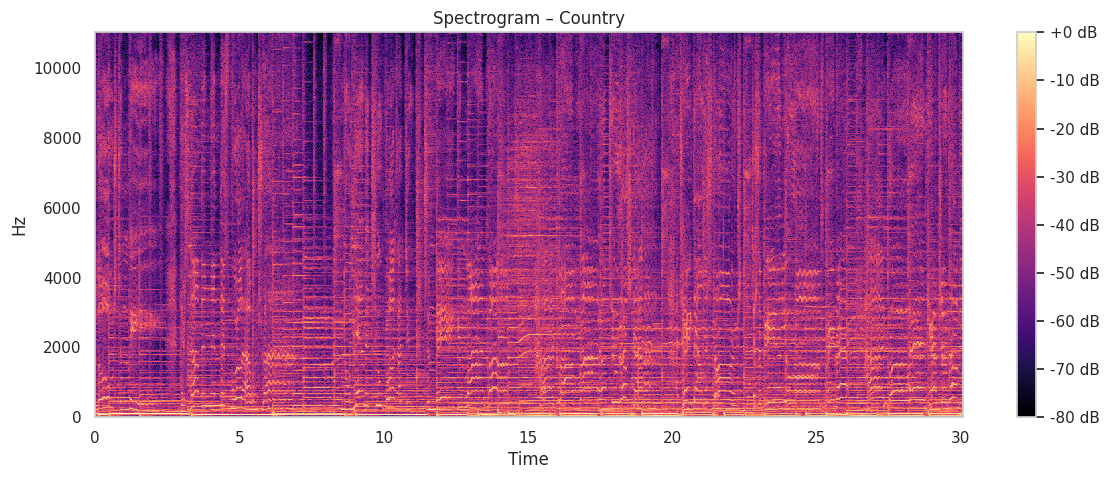

In [ ]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="hz")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram – Country")
plt.show()

In [ ]:
rows = len(genres) // 2
fig, axes = plt.subplots(rows, 2, figsize = (16, 3 * rows), sharex = True, sharey = True, constrained_layout = True)

for i, genre in enumerate(genres) :
    y, sr = load_genre_audio(genre)
    D = librosa.stft(y, n_fft = 2048, hop_length = 512)
    S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max)

    ax = axes[i // 2, i % 2]
    img = librosa.display.specshow(
        S_db,
        sr = sr,
        hop_length = 512,
        x_axis = "time",
        y_axis = "hz",
        ax = ax
    )
    ax.set_title(f"Spectrogram – {genre.capitalize()}")

fig.colorbar(img, ax = axes, format = "%+2.0f dB", location = "right")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### 4. Mel Spectrogram

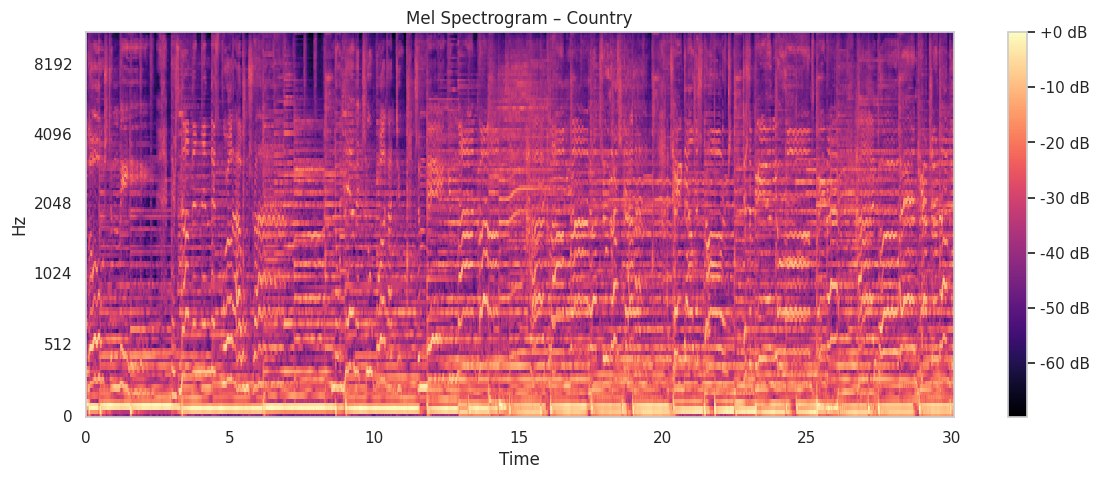

In [ ]:
mel = librosa.feature.melspectrogram(y = y, sr = sr, n_mels = 128)
mel_db = librosa.power_to_db(mel, ref = np.max)

plt.figure(figsize = (14, 5))
librosa.display.specshow(mel_db, sr = sr, x_axis = "time", y_axis = "mel")
plt.colorbar(format = "%+2.0f dB")
plt.title("Mel Spectrogram – Country")
plt.show()

In [ ]:
rows = len(genres) // 2
fig, axes = plt.subplots(rows, 2, figsize = (16, 3 * rows), sharex = True, sharey = True, constrained_layout = True)

for i, genre in enumerate(genres) :
    y, sr = load_genre_audio(genre)

    mel = librosa.feature.melspectrogram(
        y = y,
        sr = sr,
        n_fft = 2048,
        hop_length = 512,
        n_mels = 128
    )
    mel_db = librosa.power_to_db(mel, ref = np.max)

    ax = axes[i // 2, i % 2]
    img = librosa.display.specshow(
        mel_db,
        sr = sr,
        hop_length = 512,
        x_axis = "time",
        y_axis = "mel",
        ax = ax
    )
    ax.set_title(f"Mel Spectrogram – {genre.capitalize()}")

fig.colorbar(img, ax = axes, format = "%+2.0f dB", location = "right")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### 5. MFCC

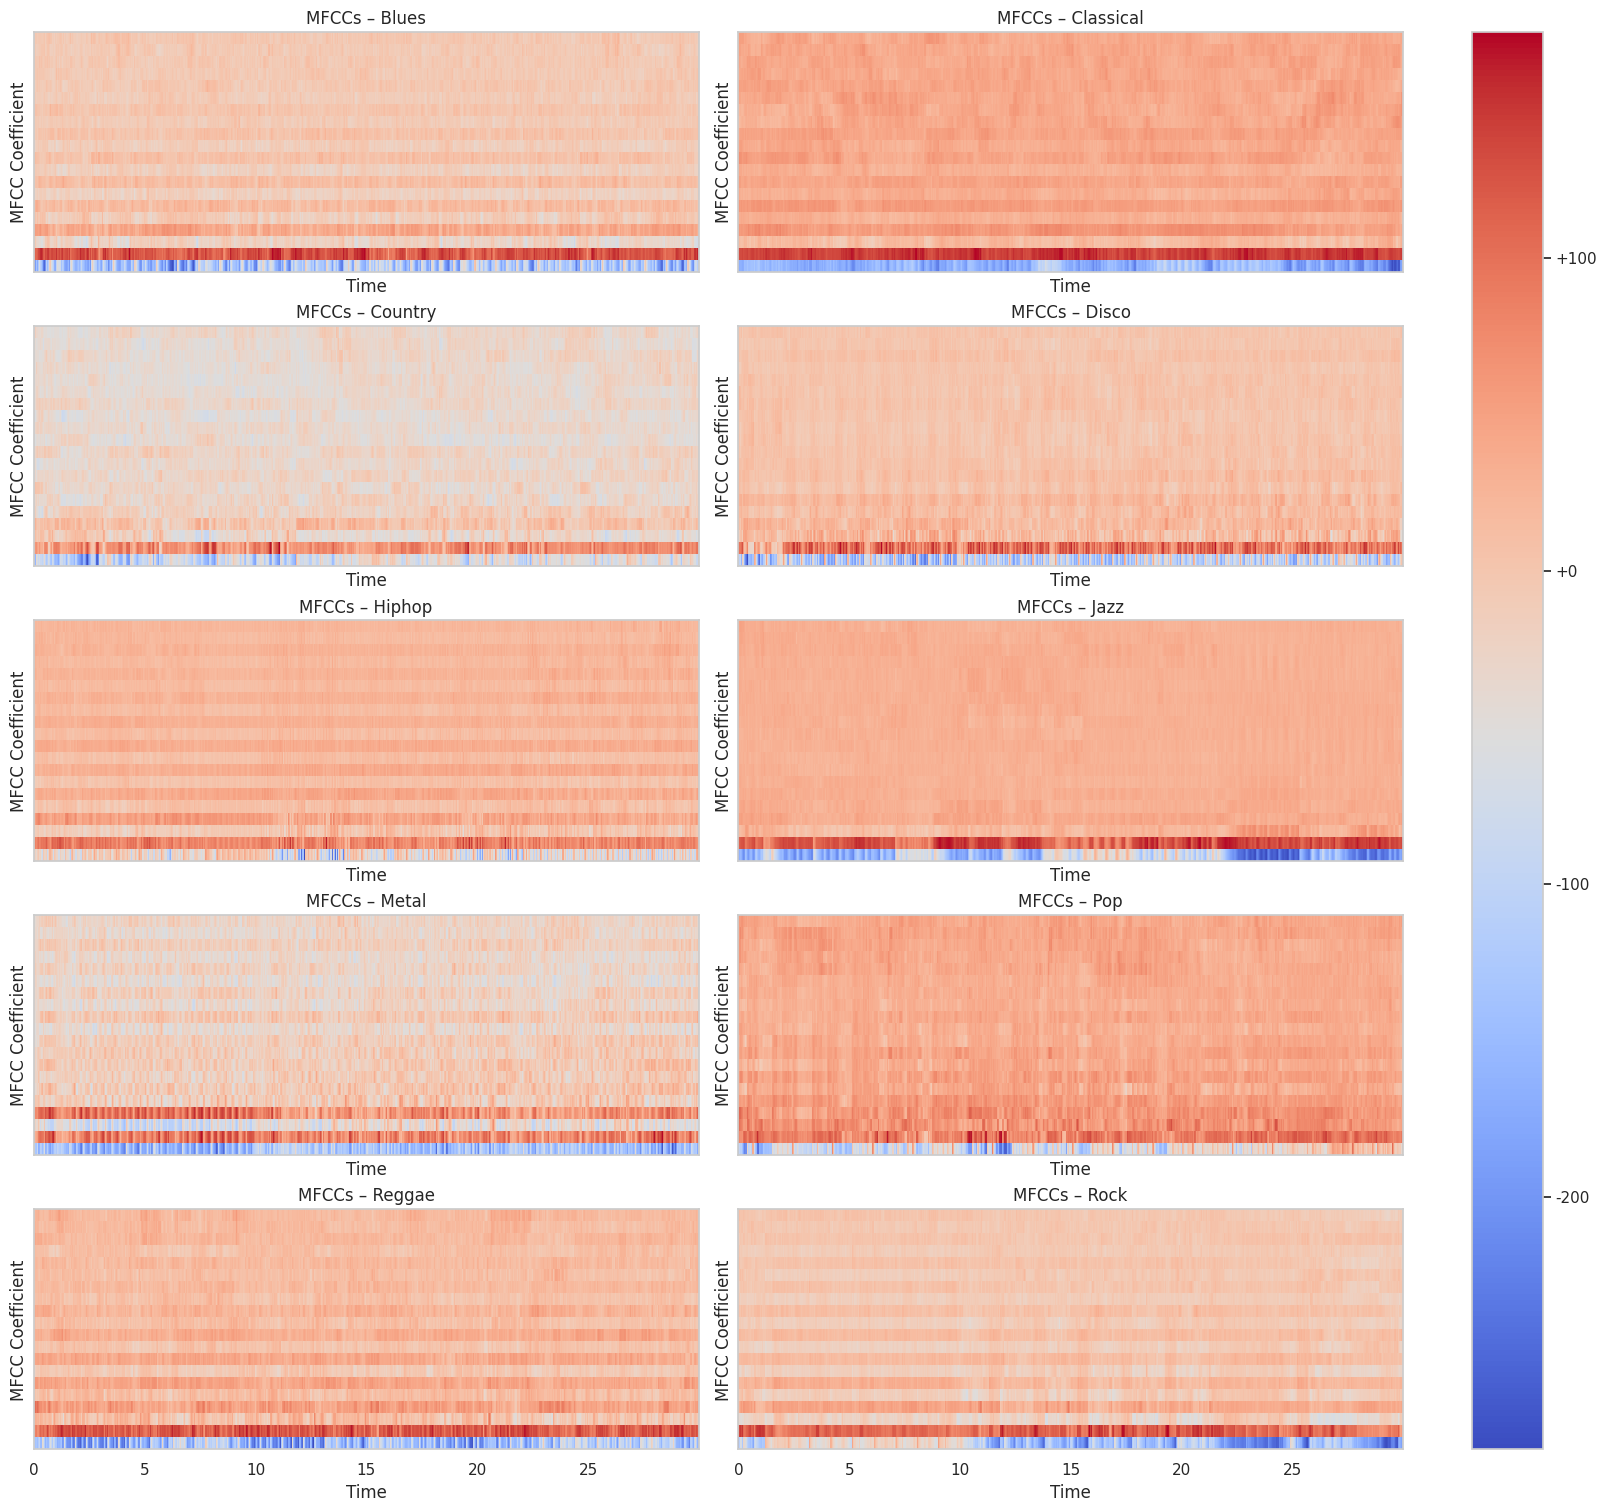

In [ ]:
N_MFCC = 20
N_FFT = 2048
HOP_LENGTH = 512

rows = len(genres) // 2

fig, axes = plt.subplots(rows, 2, figsize = (16, 3 * rows), sharex = True, sharey = True, constrained_layout = True)

for i, genre in enumerate(genres) :
    y, sr = load_genre_audio(genre)

    mfcc = librosa.feature.mfcc(
        y = y,
        sr = sr,
        n_mfcc = N_MFCC,
        n_fft = N_FFT,
        hop_length = HOP_LENGTH
    )

    ax = axes[i // 2, i % 2]
    img = librosa.display.specshow(
        mfcc,
        x_axis = "time",
        ax = ax
    )

    ax.set_title(f"MFCCs – {genre.capitalize()}")
    ax.set_ylabel("MFCC Coefficient")

fig.colorbar(img, ax = axes, format = "%+2.0f")
plt.show()

## Data Preprocessing

In [4]:
genres = sorted(os.listdir(genres_audio_path))

songs = []
for genre in genres:
    genre_dir = os.path.join(genres_audio_path, genre)
    for fname in sorted(os.listdir(genre_dir)):
        songs.append({
            "genre": genre,
            "filename": fname,
            "path": os.path.join(genre_dir, fname)
        })

songs_df = pd.DataFrame(songs)
display(songs_df)

train_df, temp_df = train_test_split(songs_df, test_size = 0.3, stratify = songs_df["genre"], random_state = 1305)
val_df, test_df = train_test_split(temp_df, test_size = 0.5, stratify = temp_df["genre"], random_state = 1305)

print("\nTrain:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

,genre,filename,path
0,blues,blues.00000.wav,/content/drive/MyDrive/Music Genre Classificat...
1,blues,blues.00001.wav,/content/drive/MyDrive/Music Genre Classificat...
2,blues,blues.00002.wav,/content/drive/MyDrive/Music Genre Classificat...
3,blues,blues.00003.wav,/content/drive/MyDrive/Music Genre Classificat...
4,blues,blues.00004.wav,/content/drive/MyDrive/Music Genre Classificat...
...,...,...,...
995,rock,rock.00095.wav,/content/drive/MyDrive/Music Genre Classificat...
996,rock,rock.00096.wav,/content/drive/MyDrive/Music Genre Classificat...
997,rock,rock.00097.wav,/content/drive/MyDrive/Music Genre Classificat...
998,rock,rock.00098.wav,/content/drive/MyDrive/Music Genre Classificat...



Train: (700, 3)
Val: (150, 3)
Test: (150, 3)


In [5]:
# Save CNN song split (ground truth split)
train_df[["filename", "genre"]].to_csv("/content/drive/MyDrive/ML_Project/cnn_train_songs.csv", index=False)
val_df[["filename", "genre"]].to_csv("/content/drive/MyDrive/ML_Project/cnn_val_songs.csv", index=False)
test_df[["filename", "genre"]].to_csv("/content/drive/MyDrive/ML_Project/cnn_test_songs.csv", index=False)

print("CNN split exported.")

CNN split exported.


In [6]:
assert set(train_df.filename).isdisjoint(val_df.filename)
assert set(train_df.filename).isdisjoint(test_df.filename)
assert set(val_df.filename).isdisjoint(test_df.filename)

print("✔ No data leakage detected")

✔ No data leakage detected


In [18]:
SAMPLE_RATE = 22050
DURATION = 30
SEGMENT_DURATION = 3.0
SEGMENT_SAMPLES = int(SAMPLE_RATE * SEGMENT_DURATION)

N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128
skipped = []

# Audio loading (fixed length)
def load_audio(path) :
    try:
        y, sr = librosa.load(path, sr = SAMPLE_RATE)
        return y

    except :
        skipped.append(path)
        return None

# Split waveform into segments
def split_audio(y) :
    segments = []
    for start in range(0, len(y) - SEGMENT_SAMPLES + 1, SEGMENT_SAMPLES) :
        segments.append(y[start : start + SEGMENT_SAMPLES])
    return segments


# Mel spectrogram extraction
def compute_mel_spectrogram(y) :
    mel = librosa.feature.melspectrogram(
        y = y,
        sr = SAMPLE_RATE,
        n_fft = N_FFT,
        hop_length = HOP_LENGTH,
        n_mels = N_MELS
    )
    mel_db = librosa.power_to_db(mel, ref = np.max)
    return mel_db

# Per-spectrogram normalization
def normalize_mel(mel) :
    mean = mel.mean()
    std = mel.std() + 1e-6
    return (mel - mean) / std

# Label encoding
label_encoder = LabelEncoder()
label_encoder.fit(songs_df["genre"])

NUM_CLASSES = len(label_encoder.classes_)
NUM_CLASSES, label_encoder.classes_

# SEGMENT-LEVEL Dataset Builder (segments inherit song label)
def build_dataset(df) :
    X, y = [], []

    for _, row in df.iterrows() :
        audio = load_audio(row["path"])
        if audio is None :
            continue

        segments = split_audio(audio)
        for seg in segments:
            mel = compute_mel_spectrogram(seg)
            mel = normalize_mel(mel)
            X.append(mel)
            y.append(row["genre"])

    X = np.array(X)[..., np.newaxis]   # (N, Mels, Time, 1)
    y = label_encoder.transform(y)

    return X, y

# Build final datasets
X_train, y_train = build_dataset(train_df)
X_val, y_val = build_dataset(val_df)
X_test, y_test = build_dataset(test_df)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)
print(f"Skipped {len(skipped)} corrupted files")

/tmp/ipython-input-3313016530.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr = SAMPLE_RATE)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


KeyboardInterrupt: 

## CNN MODEL, TRAINING, EVALUATION

In [19]:
INPUT_SHAPE = X_train.shape[1:]  # (n_mels, time, 1)

def build_cnn(input_shape, num_classes) :
    model = models.Sequential([
        layers.Input(shape = input_shape),

        layers.Conv2D(32, (3, 3), padding = "same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding = "same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding = "same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation = "relu"),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation = "softmax")
    ])

    return model

model = build_cnn(INPUT_SHAPE, NUM_CLASSES)
model.summary()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 10,
        restore_best_weights = True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.5,
        patience = 5,
        min_lr = 1e-6
    )
]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 130, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 130, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128, 130, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 64, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,370 (435.04 KB)

 Trainable params: 110,922 (433.29 KB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
EPOCHS = 50
BATCH_SIZE = 16

history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.3399 - loss: 1.8193 - val_accuracy: 0.1908 - val_loss: 3.5286 - learning_rate: 0.0010
Epoch 2/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5360 - loss: 1.3160 - val_accuracy: 0.4997 - val_loss: 1.3573 - learning_rate: 0.0010
Epoch 3/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5979 - loss: 1.1584 - val_accuracy: 0.5630 - val_loss: 1.1634 - learning_rate: 0.0010
Epoch 4/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6479 - loss: 1.0418 - val_accuracy: 0.5464 - val_loss: 1.3125 - learning_rate: 0.0010
Epoch 5/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6770 - loss: 0.9602 - val_accuracy: 0.5777 - val_loss: 1.1803 - learning_rate: 0.0010
Epoch 6/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6920 - loss: 0.9077 - val_accuracy: 0.4676 - val_loss: 1.6460 - learning_rate: 0.0010
Epoch 7/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6959 - loss: 0

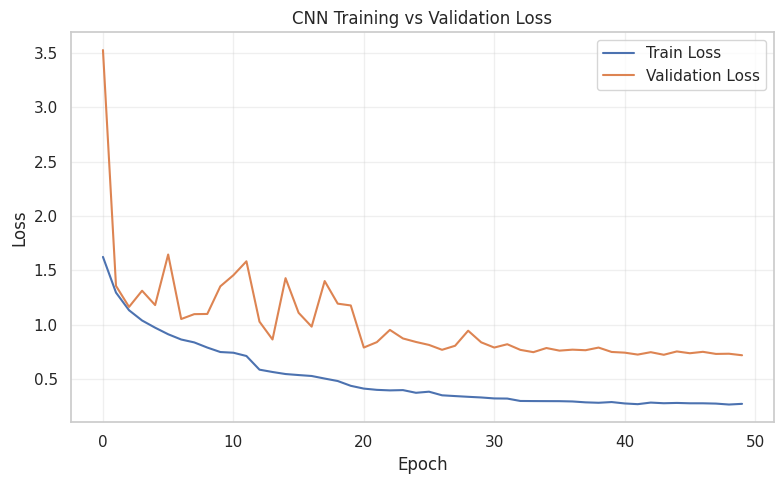

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

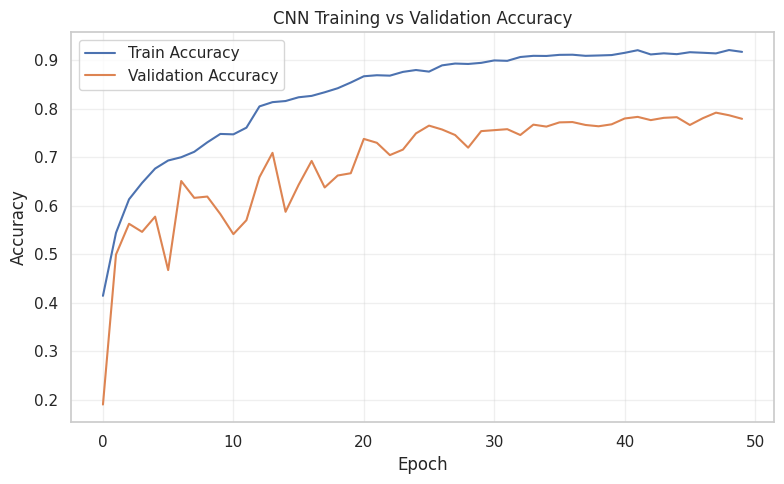

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN Training vs Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Visualize Results

### Segment-level


===== SEGMENT-LEVEL CNN PERFORMANCE =====
Accuracy: 0.8386666666666667

Classification Report (Segment-Level):
              precision    recall  f1-score   support

       blues     0.8210    0.8867    0.8526       150
   classical     0.8382    0.9667    0.8978       150
     country     0.8247    0.8467    0.8355       150
       disco     0.8986    0.8267    0.8611       150
      hiphop     0.8552    0.8267    0.8407       150
        jazz     0.9048    0.8867    0.8956       150
       metal     0.8528    0.9267    0.8882       150
         pop     0.8408    0.8800    0.8599       150
      reggae     0.9143    0.6400    0.7529       150
        rock     0.6731    0.7000    0.6863       150

    accuracy                         0.8387      1500
   macro avg     0.8423    0.8387    0.8371      1500
weighted avg     0.8423    0.8387    0.8371      1500


Segment-Level Confusion Matrix:
[[133   0   3   0   1   6   4   0   0   3]
 [  0 145   0   0   0   3   2   0   0   0]
 [  6   5 

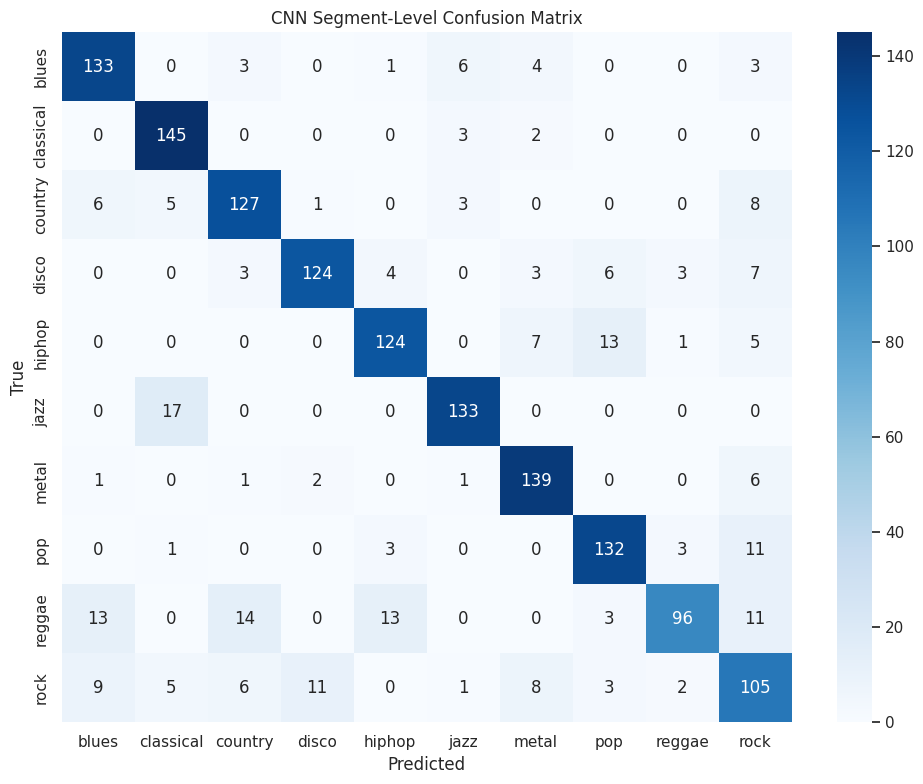

In [23]:
def build_segment_testset(df):
    X_seg, y_seg, song_ids = [], [], []

    for _, row in df.iterrows():
        audio = load_audio(row["path"])
        if audio is None:
            continue

        segments = split_audio(audio)
        for seg in segments:
            mel = compute_mel_spectrogram(seg)
            mel = normalize_mel(mel)
            X_seg.append(mel)
            y_seg.append(row["genre"])
            song_ids.append(row["filename"])

    X_seg = np.array(X_seg)[..., np.newaxis]
    y_seg = label_encoder.transform(y_seg)

    return X_seg, y_seg, np.array(song_ids)

X_seg_test, y_seg_test, song_ids = build_segment_testset(test_df)
seg_probs = model.predict(X_seg_test, verbose=0)
y_seg_pred = np.argmax(seg_probs, axis=1)

print("\n===== SEGMENT-LEVEL CNN PERFORMANCE =====")
print("Accuracy:", accuracy_score(y_seg_test, y_seg_pred))

print("\nClassification Report (Segment-Level):")
print(classification_report(
    y_seg_test,
    y_seg_pred,
    target_names=label_encoder.classes_,
    digits=4
))

cm_seg = confusion_matrix(y_seg_test, y_seg_pred)

print("\nSegment-Level Confusion Matrix:")
print(cm_seg)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_seg,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("CNN Segment-Level Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### Song-level Majority Voting

In [24]:
seg_df = pd.DataFrame({
    "song": song_ids,
    "true": y_seg_test,
    "pred": y_seg_pred
})

song_majority = seg_df.groupby("song").agg(
    true_label=("true", "first"),
    pred_label=("pred", lambda x: x.mode()[0])
).reset_index()

print("\n===== SONG-LEVEL CNN (MAJORITY VOTING) =====")
print("Accuracy:", accuracy_score(
    song_majority["true_label"],
    song_majority["pred_label"]
))

print("\nClassification Report (Majority Voting):")
print(classification_report(
    song_majority["true_label"],
    song_majority["pred_label"],
    target_names=label_encoder.classes_,
    digits=4
))


===== SONG-LEVEL CNN (MAJORITY VOTING) =====
Accuracy: 0.8866666666666667

Classification Report (Majority Voting):
              precision    recall  f1-score   support

       blues     0.8750    0.9333    0.9032        15
   classical     0.9375    1.0000    0.9677        15
     country     0.8235    0.9333    0.8750        15
       disco     0.9333    0.9333    0.9333        15
      hiphop     0.8667    0.8667    0.8667        15
        jazz     0.9333    0.9333    0.9333        15
       metal     0.8824    1.0000    0.9375        15
         pop     0.9286    0.8667    0.8966        15
      reggae     1.0000    0.6667    0.8000        15
        rock     0.7333    0.7333    0.7333        15

    accuracy                         0.8867       150
   macro avg     0.8914    0.8867    0.8847       150
weighted avg     0.8914    0.8867    0.8847       150




Song-Level Majority Confusion Matrix:
[[14  0  0  0  0  1  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  1]
 [ 0  0  0 14  1  0  0  0  0  0]
 [ 0  0  0  0 13  0  1  1  0  0]
 [ 0  1  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  2]
 [ 1  0  2  0  1  0  0  0 10  1]
 [ 1  0  1  1  0  0  1  0  0 11]]


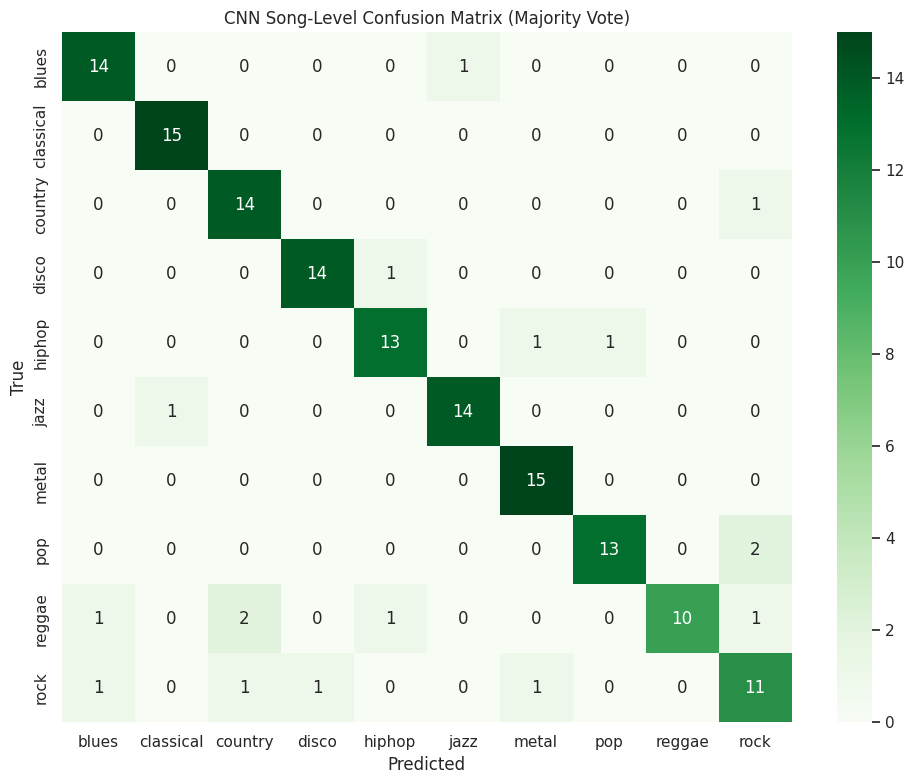

In [25]:
cm_majority = confusion_matrix(
    song_majority["true_label"],
    song_majority["pred_label"]
)

print("\nSong-Level Majority Confusion Matrix:")
print(cm_majority)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_majority,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("CNN Song-Level Confusion Matrix (Majority Vote)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### Soft voting

In [26]:
def predict_soft_voting(df):
    y_true, y_pred = [], []

    for _, row in df.iterrows():
        audio = load_audio(row["path"])
        if audio is None:
            continue

        segments = split_audio(audio)
        mels = []

        for seg in segments:
            mel = compute_mel_spectrogram(seg)
            mel = normalize_mel(mel)
            mels.append(mel)

        mels = np.array(mels)[..., np.newaxis]

        probs = model.predict(mels, verbose=0)
        mean_prob = probs.mean(axis=0)
        pred = np.argmax(mean_prob)

        y_pred.append(pred)
        y_true.append(label_encoder.transform([row["genre"]])[0])

    return np.array(y_true), np.array(y_pred)
y_true_soft, y_pred_soft = predict_soft_voting(test_df)

print("\n===== SONG-LEVEL CNN (SOFT VOTING) =====")
print("Accuracy:", accuracy_score(y_true_soft, y_pred_soft))

print("\nClassification Report (Soft Voting):")
print(classification_report(
    y_true_soft,
    y_pred_soft,
    target_names=label_encoder.classes_,
    digits=4
))


===== SONG-LEVEL CNN (SOFT VOTING) =====
Accuracy: 0.8933333333333333

Classification Report (Soft Voting):
              precision    recall  f1-score   support

       blues     0.8750    0.9333    0.9032        15
   classical     0.9375    1.0000    0.9677        15
     country     0.8235    0.9333    0.8750        15
       disco     0.9333    0.9333    0.9333        15
      hiphop     0.8667    0.8667    0.8667        15
        jazz     0.9375    1.0000    0.9677        15
       metal     0.8824    1.0000    0.9375        15
         pop     0.9286    0.8667    0.8966        15
      reggae     1.0000    0.6667    0.8000        15
        rock     0.7857    0.7333    0.7586        15

    accuracy                         0.8933       150
   macro avg     0.8970    0.8933    0.8906       150
weighted avg     0.8970    0.8933    0.8906       150




Song-Level Soft Voting Confusion Matrix:
[[14  0  0  0  0  1  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0]
 [ 0  1 14  0  0  0  0  0  0  0]
 [ 0  0  0 14  1  0  0  0  0  0]
 [ 0  0  0  0 13  0  1  1  0  0]
 [ 0  0  0  0  0 15  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  2]
 [ 1  0  2  0  1  0  0  0 10  1]
 [ 1  0  1  1  0  0  1  0  0 11]]


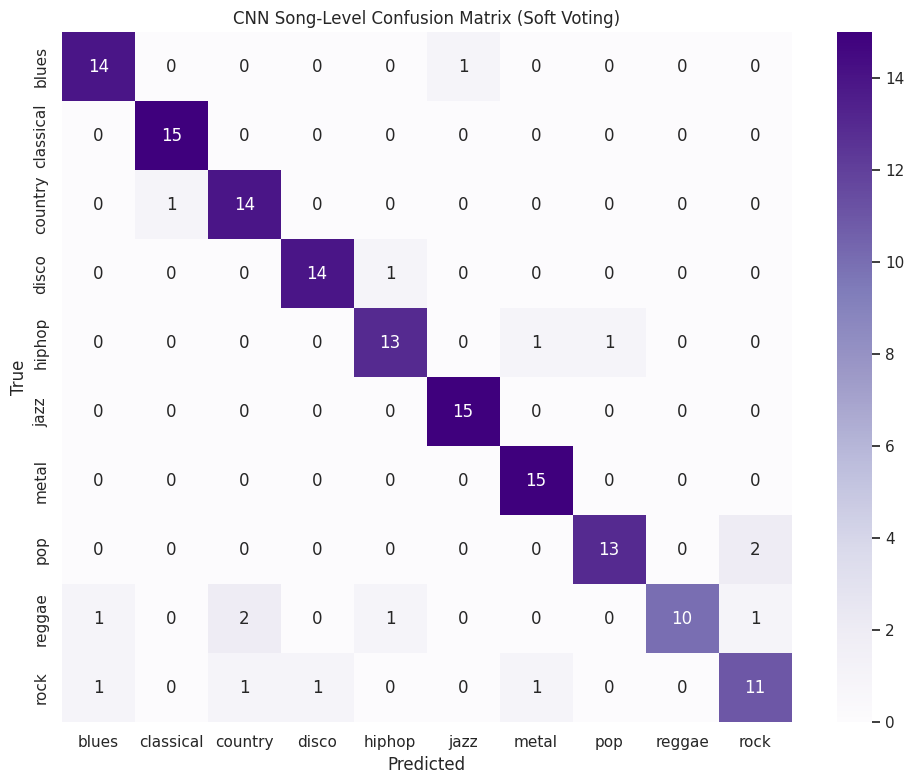

In [27]:
cm_soft = confusion_matrix(y_true_soft, y_pred_soft)

print("\nSong-Level Soft Voting Confusion Matrix:")
print(cm_soft)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_soft,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("CNN Song-Level Confusion Matrix (Soft Voting)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## Add noise

In [17]:
def add_gaussian_noise(y, level="small"):
    if level == "small":
        scale = np.random.uniform(0.001, 0.003)
    elif level == "medium":
        scale = np.random.uniform(0.003, 0.008)
    else:
        raise ValueError("level must be 'small' or 'medium'")

    noise = np.random.randn(len(y))
    return y + scale * noise

def build_dataset_with_noise(
    df,
    noise_prob=0.5,
    noise_level="small"
):
    X, y = [], []

    for _, row in df.iterrows():
        audio = load_audio(row["path"])
        if audio is None:
            continue

        segments = split_audio(audio)

        for seg in segments:
            # ---- ADD NOISE HERE (TRAIN ONLY) ----
            if random.random() < noise_prob:
                seg = add_gaussian_noise(seg, noise_level)

            mel = compute_mel_spectrogram(seg)
            mel = normalize_mel(mel)

            X.append(mel)
            y.append(row["genre"])

    X = np.array(X)[..., np.newaxis]
    y = label_encoder.transform(y)

    return X, y

# 🔥 TRAIN WITH NOISE
X_train, y_train = build_dataset_with_noise(
    train_df,
    noise_prob=0.5,      # try 0.3–0.7
    noise_level="small"  # start small
)

# ❄️ VALIDATION & TEST CLEAN
X_val, y_val = build_dataset(val_df)
X_test, y_test = build_dataset(test_df)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

/tmp/ipython-input-3313016530.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr = SAMPLE_RATE)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Train: (6982, 128, 130, 1)
Val: (1499, 128, 130, 1)
Test: (1500, 128, 130, 1)
